In [3]:
import pystan
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

np.random.seed(101)

A first-order autoregressive model (AR(1)) with normal noise takes each point yn in a sequence y to be generated according to:

$$ y_{n} \sim N(\alpha + \beta y_{n-1}, \sigma)$$

That is, the expected value of $y_{n}$ is $\alpha + \beta y_{n-1} $ with noise scaled as $\sigma$.

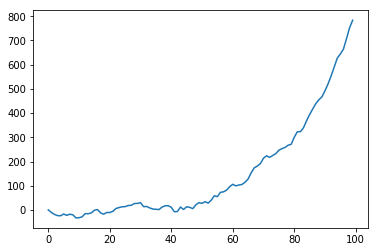

In [34]:
def build_data(n, alpha=1.1, beta=1.05, sigma=9.4):
    
    # empty array for y
    y = []
    
    # initial value of y -> y[0]
    y.append(alpha*np.random.rand())
    
    # generating the autoregressive sequence
    for i in range(1,n):
        y.append(np.random.normal(alpha + beta*y[-1], scale=sigma))
    
    plt.plot(y)
    
    return y

y = build_data(100)

The next thing we need to do is to define our Stan model, [Stan Reference Manual](http://mc-stan.org/users/documentation/):

In [35]:
def stan_model():
    model = """
        data {
            int<lower=0> N; //number of observations
            vector[N] y;    //outcome vector
        }

        parameters {
            real alpha;          //intercept
            real beta;           //slope
            real<lower=0> sigma; //error scale
        }

        model {
            for (n in 2:N)
                y[n] ~ normal(alpha + beta * y[n-1], sigma); //likelihood
        }
    """
    
    return model

model = stan_model()

Once this is done the next step is to convert our 'observed' data into Stan-friendly format, compile and train the model:

In [36]:
# converting the data into a dictionary
data = {'N': len(y), 'y': y}

# compiling the mdoel
sm = pystan.StanModel(model_code=model)

# training the model and generating samples
### iter - the total number of samples that will be generated from each Markov chain
### chains - the number of chains from which samples will be combined to form the posterior distribution
### warmup - the amount of samples that will be discarded from the beginning of each chain
### thin - an interval in sampling at which samples are retained
fit = sm.sampling(data=data, iter=1000, chains=250, warmup=500, thin=5, seed=101)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b64b24d51e75cb568bdbf133c3d83e6e NOW.
C:\Users\vasil\AppData\Local\Continuum\anaconda3\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\vasil\AppData\Local\Temp\tmpuldv_lbw\stanfit4anon_model_b64b24d51e75cb568bdbf133c3d83e6e_1154802091366662428.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Diagnostics of the model:

In [37]:
summary_dict = fit.summary()
df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])

df

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
alpha,1.259764,0.006790,1.062518,-0.801798,0.549127,1.258579,1.961951,3.347916,24489.545564,1.000884
beta,1.047827,0.000028,0.004399,1.039211,1.044878,1.047822,1.050755,1.056460,25458.077675,1.000350
sigma,8.694002,0.004011,0.635109,7.559777,8.254188,8.650495,9.093245,10.062520,25067.108857,1.000209
lp__,-260.608788,0.007916,1.241419,-263.847539,-261.166388,-260.281598,-259.698896,-259.206603,24595.884663,0.999810


In [39]:
alpha = fit['alpha']
beta = fit['beta']
sigma = fit['sigma']

So from the diagnostics we can observe that we have pretty good estimates for $\alpha$, $\beta$ and $\sigma$. As you know a solution to a Bayesian Inference problem is a **probability distribution** for the unknown parameters.

C:\Users\vasil\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


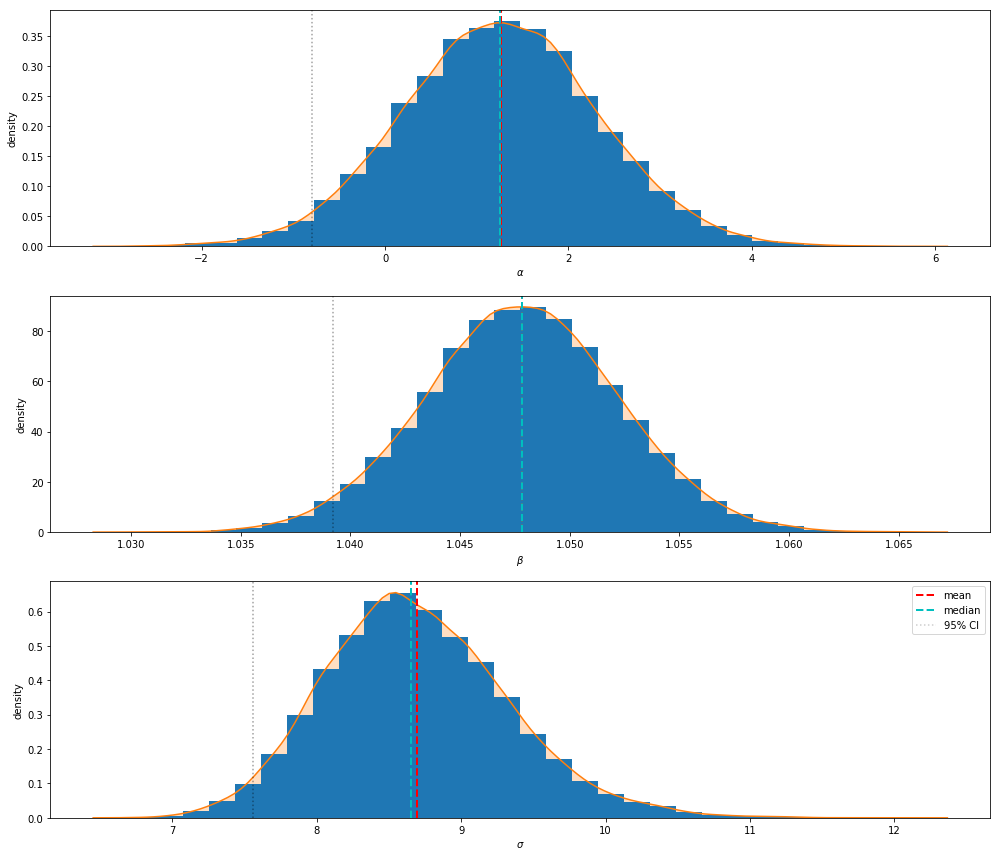

In [40]:
def distribution(params, param_names):
    
    mean = []
    median = []
    conf_int = []
    
    for param in params:
        mean.append(np.mean(param))
        median.append(np.median(param))
        conf_int.append((np.percentile(param, 2.5), np.percentile(param, 97.5)))
        
    plt.rcParams['figure.figsize'] = (14,12)
    for i in range(0,len(params)):
        plt.subplot(len(params), 1, i+1)
        plt.hist(params[i], bins=30, density=True)
        sns.kdeplot(params[i], shade=True)
        plt.xlabel(param_names[i])
        plt.ylabel('density')
        plt.axvline(mean[i], color='r', lw=2, linestyle='--',label='mean')
        plt.axvline(median[i], color='c', lw=2, linestyle='--',label='median')
        plt.axvline(conf_int[i][0], linestyle=':', color='k', alpha=0.2, label='95% CI')
        plt.axvline(conf_int[i][0], linestyle=':', color='k', alpha=0.2)
        
    plt.gcf().tight_layout()
    plt.legend()

# plotting the probability distributions of the variables
distribution([alpha,beta,sigma], [r'$\alpha$', r'$\beta$', r'$\sigma$'])